In [11]:
%load_ext autoreload
%autoreload 2
from ordinal_ranker import *
from fillna import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import model_selection as ms
plt.rcParams["text.usetex"] = False

Load in the data and merge the sample submission with the test dataset

In [13]:
house_price = pd.read_csv('train.csv')
house_test = pd.read_csv('test.csv')
sub_ys=pd.read_csv('sample_submission.csv')
house_test = pd.merge(house_test,sub_ys,how = 'inner', on = 'Id')

Log Transform SalePrice

In [14]:
house_price["SalePrice"] = np.log1p(house_price["SalePrice"])

Drop SalePrice from the dataset and make it a Dependent Variable

In [15]:
house_price_target = house_price['SalePrice'].reset_index(drop=True)
house_price = house_price.drop(['SalePrice'], axis=1)
house_test = house_test.drop(['SalePrice'], axis=1)

Concat the test and train dataset

In [16]:
data = pd.concat([house_price, house_test])

Process the data

In [17]:
data = data_process(data)

Check the shape

In [18]:
data.shape

(2919, 179)

Recreate the train and test set

In [19]:
train = data.iloc[:house_price.shape[0],:]
test = data.iloc[house_price.shape[0]:,:]

In [20]:
train.shape, test.shape

((1460, 179), (1459, 179))

Scale all of the columns

In [21]:
x_scaled = (train-train.min(axis=0))/(train.max(axis=0)-train.min(axis=0))

Seperate the train data using train test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, house_price_target, test_size=0.2, random_state=42)

## Ridge Model

In [23]:
ridge = Ridge(normalize=True)

In [24]:
ridge.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [25]:
ridge.score(X_train,y_train)

0.8700123759997483

In [26]:
ridge.score(X_test,y_test)

0.8553121178570507

Plot the Train-Test R2 Comparison

In [35]:
ridge_scores_train = []
ridge_scores_test  = []

alphas = np.linspace(0.01, 1, 100)

for alpha in alphas:
            ridge.set_params(alpha=alpha, normalize=True)
            ridge.fit(X_train,y_train)
            ridge_scores_train.append(ridge.score(X_train,y_train))
            ridge_scores_test.append(ridge.score(X_test,y_test))
ridge_scores_train = np.array(ridge_scores_train) 
ridge_scores_test  = np.array(ridge_scores_test)

Text(0, 0.5, '$R^2$')

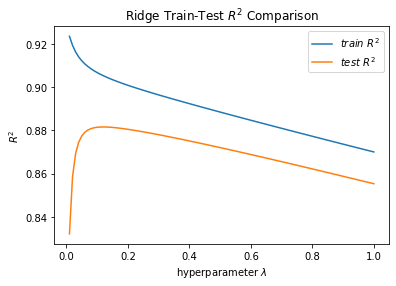

In [36]:
plt.plot(alphas, ridge_scores_train, label=r'$train\ R^2$')
plt.plot(alphas, ridge_scores_test, label=r'$test\ R^2$')
plt.legend(loc=1)
plt.title(r'Ridge Train-Test $R^2$ Comparison')
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

## Lasso Model

In [27]:
lasso = Lasso(alpha=0.0007, normalize = True, selection = 'cyclic', max_iter=100000)

In [28]:
lasso.fit(X_train,y_train)

Lasso(alpha=0.0007, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
lasso.score(X_train,y_train)

0.8270320123292009

In [30]:
lasso.score(X_test,y_test)

0.8290566405640989

Plot the Train-Test R2 Comparison

In [37]:
lasso_scores_train = []
lasso_scores_test  = []

alphas = np.linspace(0.0005, 0.001, 10)

for alpha in alphas:
            lasso.set_params(alpha=alpha, normalize = True, selection = 'cyclic', max_iter=100000)
            lasso.fit(X_train,y_train)
            lasso_scores_train.append(lasso.score(X_train,y_train))
            lasso_scores_test.append(lasso.score(X_test,y_test))
lasso_scores_train = np.array(lasso_scores_train) 
lasso_scores_test  = np.array(lasso_scores_test)

Text(0, 0.5, '$R^2$')

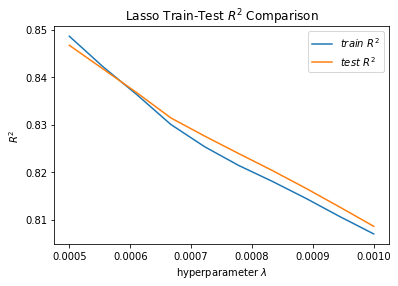

In [38]:
plt.plot(alphas, lasso_scores_train, label=r'$train\ R^2$')
plt.plot(alphas, lasso_scores_test, label=r'$test\ R^2$')
plt.legend(loc=1)
plt.title(r'Lasso Train-Test $R^2$ Comparison')
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

## ElasticNet Model

In [31]:
ENet = ElasticNet(alpha=0.0007, l1_ratio=0.3, fit_intercept=True, normalize=True, precompute=False, max_iter=100000, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

In [32]:
ENet.fit(X_train,y_train)

ElasticNet(alpha=0.0007, copy_X=True, fit_intercept=True, l1_ratio=0.3,
           max_iter=100000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [33]:
ENet.score(X_train,y_train)

0.8613371874346896

In [34]:
ENet.score(X_test,y_test)

0.8524258351267283

Get the coefficients of the model and add them to a dataframe

In [39]:
coefs = list(zip(data.columns[data.columns!='SalePrice'],list(ridge.coef_)))
ridge_coef = sorted(coefs, key=lambda element: (element[0], element[1]))
ridge_coef_df = pd.DataFrame(ridge_coef)
ridge_coef_df

,0,1
0,Alley_NA,0.008455
1,Alley_Pave,0.006462
2,BedroomAbvGr,0.174795
3,BsmtCond,0.053536
4,BsmtExposure,0.053842
...,...,...
174,TotalBsmtSF,0.328343
175,Utilities,0.096384
176,WoodDeckSF,0.091908
177,YearRemodAdd,0.058530


Get the highest correlated coefficients

In [40]:
ridge_ceof_high = ridge_coef_df[abs(ridge_coef_df[1])>0.04]
ridge_ceof_high = ridge_ceof_high.set_index(0)
ridge_ceof_high

,1
0,
BedroomAbvGr,0.174795
BsmtCond,0.053536
BsmtExposure,0.053842
BsmtFinSF1,0.151310
BsmtFinSF2,0.040335
...,...
ThreSsnPorch,0.071819
TotalBsmtSF,0.328343
Utilities,0.096384


Plot the coefficients

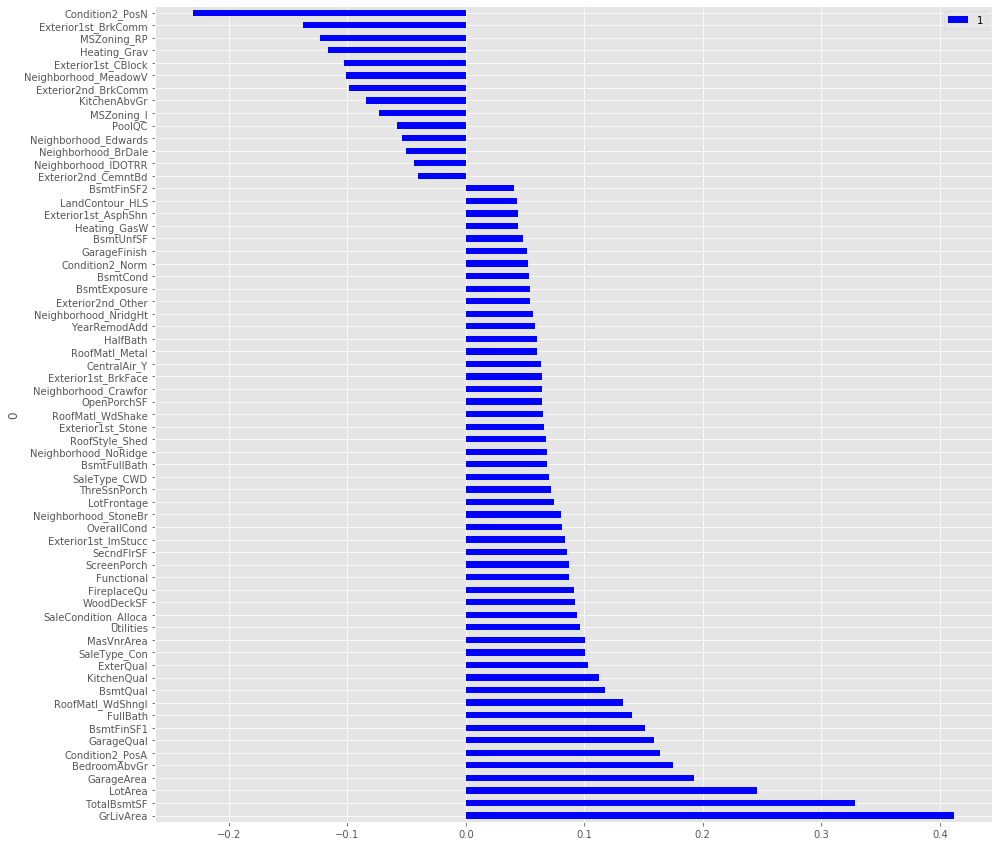

In [41]:
matplotlib.rc('figure', figsize=(15, 15))
plt.style.use('ggplot')
ridge_ceof_high.sort_values(ascending=False, by = 1).plot.barh(color='b')